# Chapter 6 Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [11]:
from IPython.display import Image
%matplotlib inline

In [12]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Streamlining workflows with pipelines

### Loading the Breast Cancer Wisconsin dataset

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y=le.fit_transform(y)

In [2]:
le.transform(['M','B'])

array([1, 0], dtype=int64)

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

C:\Users\charlie_chiu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Combining transformers and estimators in a pipeline

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Train Accuracy: %.3f' % pipe_lr.score(X_train, y_train))
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Train Accuracy: 0.954
Test Accuracy: 0.947


## Using k-fold cross-validation to assess model preformance

### The stratified k-fold

In [5]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores=[]
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, ACC: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], ACC: 0.891
Fold: 2, Class dist.: [256 153], ACC: 0.978
Fold: 3, Class dist.: [256 153], ACC: 0.978
Fold: 4, Class dist.: [256 153], ACC: 0.913
Fold: 5, Class dist.: [256 153], ACC: 0.935
Fold: 6, Class dist.: [257 153], ACC: 0.978
Fold: 7, Class dist.: [257 153], ACC: 0.933
Fold: 8, Class dist.: [257 153], ACC: 0.956
Fold: 9, Class dist.: [257 153], ACC: 0.978
Fold: 10, Class dist.: [257 153], ACC: 0.956


In [6]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


### Alternative: Using `cross_val_score` to calculate the score

In [7]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [8]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


## Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

C:\Users\charlie_chiu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


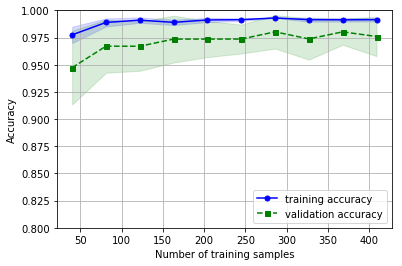

In [9]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('clf', LogisticRegression(penalty='l2', random_state=0)),])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### Addressing overfitting and underfitting with validation curves

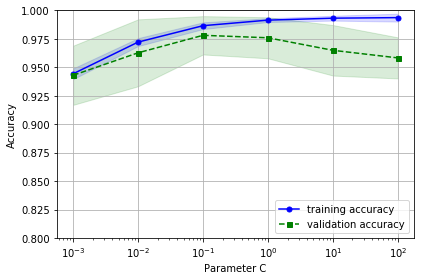

In [13]:
if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import validation_curve
else:
    from sklearn.model_selection import validation_curve



param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

## Fine-tuning machine learning model via grid search

### Tuning hyperparameters via grid search

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.978021978021978


In [25]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}
